# Overview

The goal of this notebook is to find and test different ways of clustering phone screen view data as a preprocessing step before further extraction and classification. The main focus is placed on spacial data.

In [1]:
import numpy as np
import pandas as pd
from typing import Optional
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

In [2]:
coupon_df = pd.read_csv('data/18929485529.csv')
coupon_df.head()

,ID,User ID,Time,I,Language,Application Name,Package Name,Class Name,Context,View ID,View Depth,View Class Name,Text,Description,Seen Timestamp,Is Visible,X 1,Y 1,X 2,Y 2
0,18929485529,165559,2024-09-04T10:55:25.287,1,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,0,de.penny.app.main.view.MainActivity,NaN,NaN,0,False,0,0,0,0
1,18929485529,165559,2024-09-04T10:55:25.287,2,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,android:id/content,2,android.widget.FrameLayout,NaN,NaN,1725440082464,True,0,0,1080,2400
2,18929485529,165559,2024-09-04T10:55:25.287,3,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,UVP 14.99,NaN,1725440082464,True,339,833,498,874
3,18929485529,165559,2024-09-04T10:55:25.287,4,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,9.99,NaN,1725440082464,True,356,884,482,960
4,18929485529,165559,2024-09-04T10:55:25.287,5,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,UVP,NaN,1725440082464,True,63,986,125,1027


I define auxiliary functions and modify the data to facilitate of further analysis.

In [3]:
class BoundingBox:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = min(x1, x2)
        self.y1 = min(y1, y2)
        self.x2 = max(x1, x2)
        self.y2 = max(y1, y2)

    def intersects(self, other: 'BoundingBox') -> bool:
        if self.x1 >= other.x2 or self.x2 <= other.x1:
            return False

        if self.y1 >= other.y2 or self.y2 <= other.y1:
            return False

        return True

    def merge(self, other: 'BoundingBox') -> 'BoundingBox':
        return BoundingBox(
            min(self.x1, other.x1),
            min(self.y1, other.y1),
            max(self.x2, other.x2),
            max(self.y2, other.y2)
        )

    def intersection(self, other: 'BoundingBox') -> Optional['BoundingBox']:
        if not self.intersects(other):
            return None

        return BoundingBox(
            max(self.x1, other.x1),
            max(self.y1, other.y1),
            min(self.x2, other.x2),
            min(self.y2, other.y2)
        )

    def area(self):
        return (self.x2 - self.x1) * (self.y2 - self.y1)

    def IoU(self, other: 'BoundingBox'):
        if not self.intersects(other):
            return 0

        inter_area = self.intersection(other).area()

        return inter_area / (self.area() + other.area() - inter_area)

    def apply_bias(self, xbias, ybias):
        return BoundingBox(
            self.x1 - xbias,
            self.y1 - ybias,
            self.x2 + xbias,
            self.y2 + ybias
        )

def create_bounding_box(row):
    return BoundingBox(
        row['X 1'],
        row['Y 1'],
        row['X 2'],
        row['Y 2']
    )

coupon_df_mod = coupon_df.copy()
coupon_df_mod['Bounding Box'] = coupon_df_mod.apply(create_bounding_box, axis=1)
coupon_df_mod.drop(columns=['X 1', 'Y 1', 'X 2', 'Y 2'], inplace=True)

I group data by 'Application Name', since view elements from different applications should not be a part of the same cluster and 'Seen Timestamp', since the bounding box data will be unreliable at different points in time.

In [4]:
grouping_columns = ['Application Name', 'Seen Timestamp']
grouped_coupon_dfs = [group for _, group in coupon_df_mod.groupby(grouping_columns)]

I choose a group of view elements, that I will be using to roughly test the clustering algorithms and calculate their distance matrix. The distance that I use here is the inverse of the Jaccard index of bounding boxes, where in the case of no intersection an arbitrarily large value is taken. To address the issue of the lack of intersection between the bounding boxes I introduce an xbias and a ybias which will enlarge the bounding boxes in the x and y dimensions respectively. I apply hierarchical clustering with single, average and complete linkage and visualize the results.

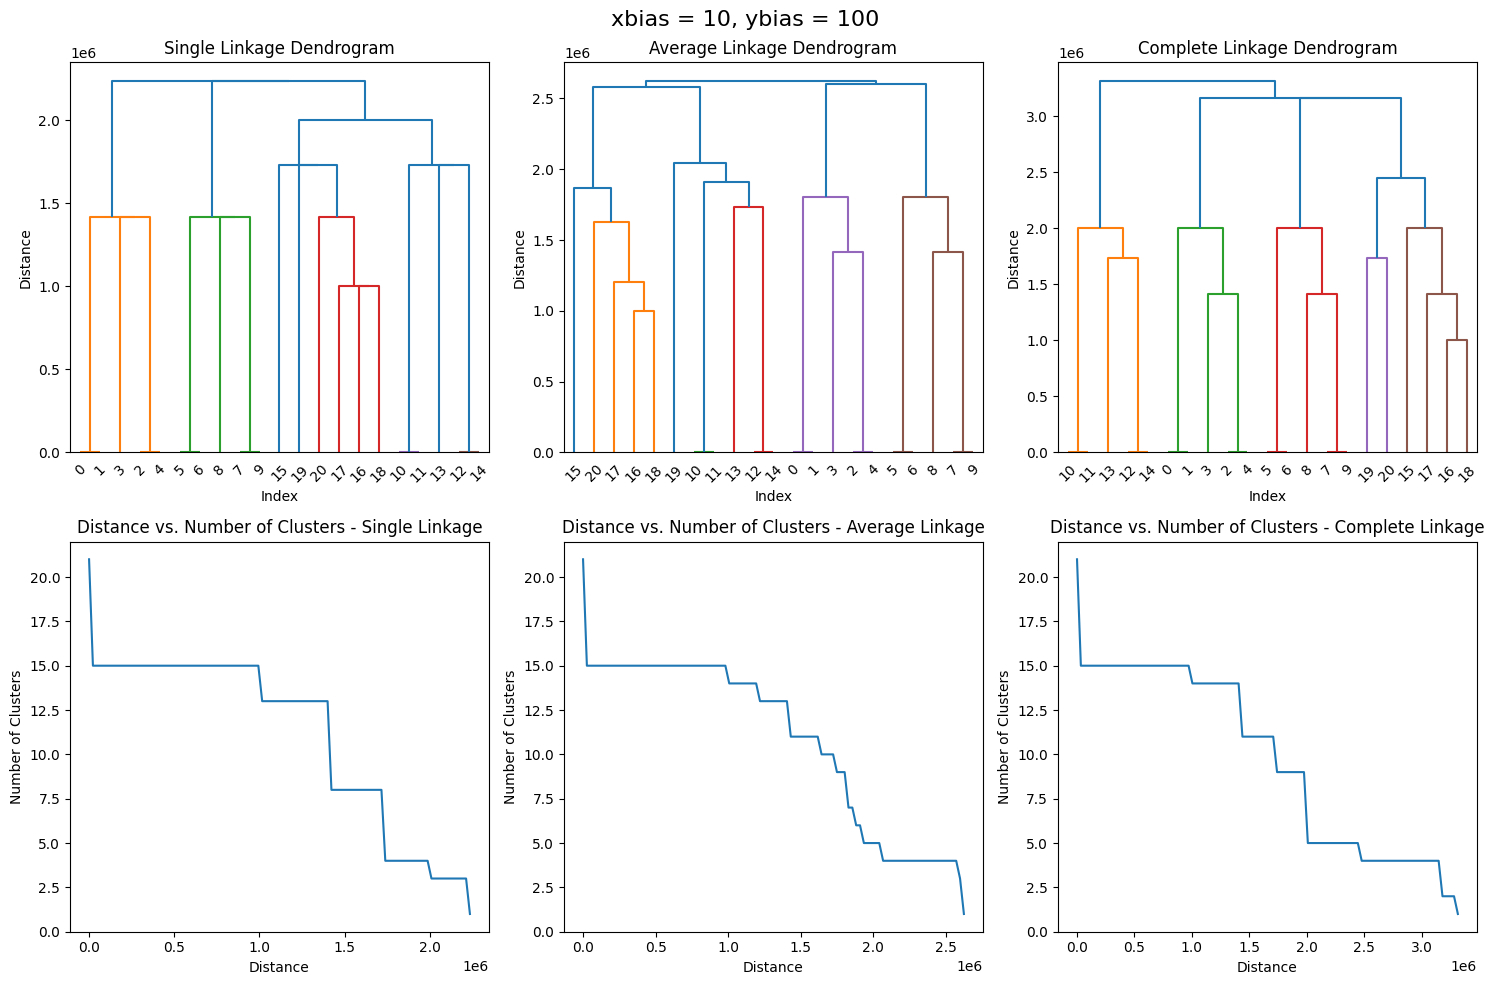

In [5]:
test_df = grouped_coupon_dfs[3]

def calculate_dist_mat(data, xbias, ybias):
    num_rows = data.shape[0]
    dists = np.empty((num_rows, num_rows))

    for i in range(num_rows):
        for j in range(num_rows):
            dists[i, j] = 1 / (data['Bounding Box'].iloc[i].apply_bias(xbias, ybias)
                               .IoU(data['Bounding Box'].iloc[j].apply_bias(xbias, ybias)) + 1e-6)

    return dists

def clusters_vs_distance(linkage):
    max_distance = max(linkage[:, 2])
    distances = np.linspace(0, max_distance, 100)
    num_clusters = []

    for d in distances:
        cluster_labels = fcluster(linkage, t=d, criterion='distance')
        num_clusters.append(len(np.unique(cluster_labels)))

    return distances, num_clusters

def link_and_visualize(distance_matrix, plot_group_title=None):
    linkage_single = linkage(distance_matrix, method='single')
    linkage_average = linkage(distance_matrix, method='average')
    linkage_complete = linkage(distance_matrix, method='complete')

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    if plot_group_title:
        plt.suptitle(plot_group_title, fontsize=16)

    dendrogram(linkage_single, ax=axs[0, 0])
    axs[0, 0].set_title('Single Linkage Dendrogram')
    axs[0, 0].set_xlabel('Index')
    axs[0, 0].set_ylabel('Distance')

    dendrogram(linkage_average, ax=axs[0, 1])
    axs[0, 1].set_title('Average Linkage Dendrogram')
    axs[0, 1].set_xlabel('Index')
    axs[0, 1].set_ylabel('Distance')

    dendrogram(linkage_complete, ax=axs[0, 2])
    axs[0, 2].set_title('Complete Linkage Dendrogram')
    axs[0, 2].set_xlabel('Index')
    axs[0, 2].set_ylabel('Distance')

    dists_single, n_clusters_single = clusters_vs_distance(linkage_single)
    axs[1, 0].plot(dists_single, n_clusters_single)
    axs[1, 0].set_title('Distance vs. Number of Clusters - Single Linkage')
    axs[1, 0].set_xlabel('Distance')
    axs[1, 0].set_ylabel('Number of Clusters')

    dists_average, n_clusters_average = clusters_vs_distance(linkage_average)
    axs[1, 1].plot(dists_average, n_clusters_average)
    axs[1, 1].set_title('Distance vs. Number of Clusters - Average Linkage')
    axs[1, 1].set_xlabel('Distance')
    axs[1, 1].set_ylabel('Number of Clusters')

    dists_complete, n_clusters_complete = clusters_vs_distance(linkage_complete)
    axs[1, 2].plot(dists_complete, n_clusters_complete)
    axs[1, 2].set_title('Distance vs. Number of Clusters - Complete Linkage')
    axs[1, 2].set_xlabel('Distance')
    axs[1, 2].set_ylabel('Number of Clusters')

    plt.tight_layout()
    plt.show()

def cluster_and_visualize(data, xbias, ybias):
    distance_matrix = calculate_dist_mat(data=data, xbias=xbias, ybias=ybias)
    link_and_visualize(distance_matrix=distance_matrix, plot_group_title=f'xbias = {xbias}, ybias = {ybias}')
    
cluster_and_visualize(data=test_df, xbias=10, ybias=100)

Comparing the data with the expected output, this seems like a decent first step. It can also be noted that the differences in linkage methods are not significant. The challenges that remain are to find a way of evaluating the clustering to find proper hyperparameters (xbias and ybias) and find an appropriate distance threshold. Let us examine the outcome of clustering with different hyperparameters.

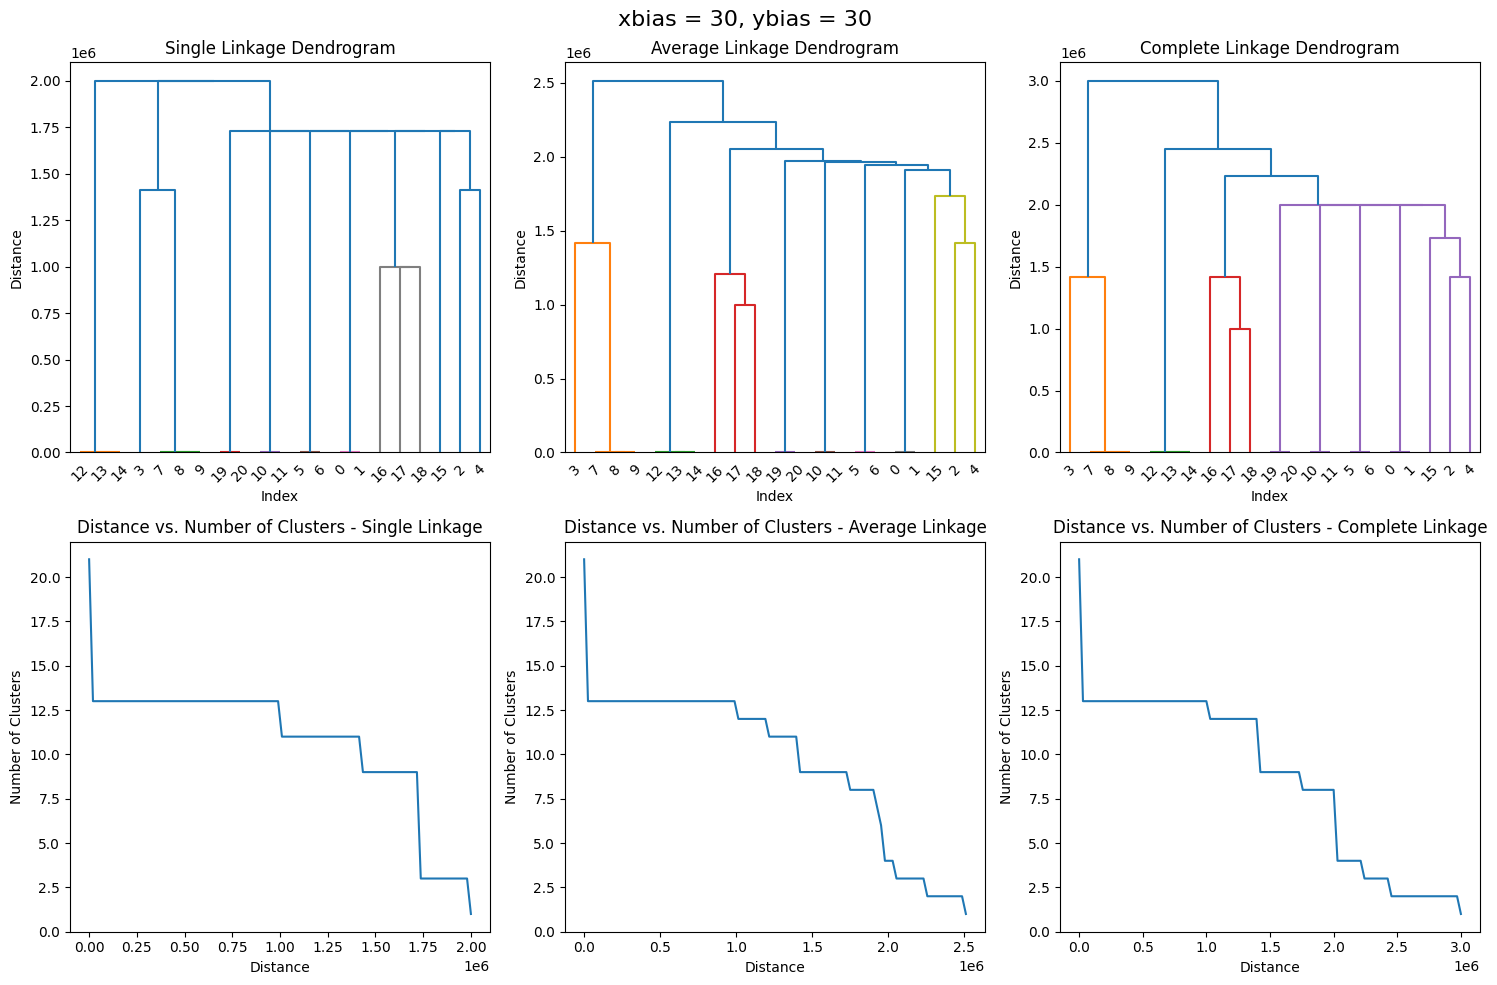

In [6]:
cluster_and_visualize(data=test_df, xbias=30, ybias=30)

The choice of xbias and ybias here is noticeably worse, yet the Distance vs. Number of Clusters plots don't seem to provide much help in detecting that. The dendrograms on the other hand merit further examination.